In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib
import matplotlib.pyplot as plt
sns.color_palette('viridis')
raw_data = pd.read_csv('../data/redfin_cleaned.csv')
raw_data.Price = raw_data.Price.values/10**3

In [32]:
# Drop some columns
drop_cols = ['Address',
             'KtoFiveType','KtoSixType',
             'NinetoTwelveType',
             'SeventoEightType', 'SixtoEightType',
             'Zip','Community',
             'RedfinEstimate','PricePerSqFt']
raw_data.drop(drop_cols, axis=1, inplace=True)
raw_data = raw_data.loc[raw_data.Price.notna()]
raw_data = raw_data.loc[(raw_data.Longitude<0) & (raw_data.Longitude.notna())]
raw_data = raw_data.loc[(raw_data.Latitude>0) & (raw_data.Latitude.notna())]
raw_data.shape

(11873, 38)

In [33]:
# Remove Outliers
cols = raw_data.columns[raw_data.dtypes!='object']
outlier_data = pd.DataFrame(index=raw_data.index)
for col in cols.drop(['Latitude','Longitude']):
    std = (raw_data[col].values - raw_data[col].mean())/raw_data[col].std()
    outlier_data[col] = std
outlier_index = outlier_data.index[(np.abs(outlier_data)>3.5).any(axis=1)]
raw_data = raw_data.drop(outlier_index, axis=0)
raw_data['LatLon'] = raw_data['Latitude'].values * raw_data['Longitude'].values

In [34]:
# Split Data
from sklearn.model_selection import train_test_split
rng = np.random.RandomState(17)
test_size = 0.2
data_train_full, data_test = train_test_split(raw_data, random_state=rng, test_size=test_size)

In [35]:
# Split Data Again
data_train, data_valid = train_test_split(data_train_full, random_state=rng, test_size=test_size)

In [36]:
# X, y datasets
X_train = data_train.drop(['Price','City'],axis=1).copy()
X_valid = data_valid.drop(['Price','City'],axis=1).copy()
X_test = data_test.drop(['Price','City'],axis=1).copy()
y_train = data_train['Price'].values
y_valid = data_valid['Price'].values
y_test = data_test['Price'].values

cat_attribs = X_train.columns[X_train.dtypes=='object']
cat_attribs = list(cat_attribs)
cat_attribs = sorted(cat_attribs)
cat_attribs

['CentralAir',
 'CloseToOutdoors',
 'CommonWalls',
 'Fireplace',
 'HighCeiling',
 'KitchenIsland',
 'Levels',
 'Patio',
 'Pool',
 'PropertyType',
 'Spa',
 'WalkInCloset']

In [37]:
num_attribs = list(set(list(X_train)) - set(cat_attribs))
num_attribs = sorted(num_attribs)
num_attribs

['Baths',
 'Beds',
 'BikeScore',
 'GarageSpaces',
 'KtoFiveDist',
 'KtoFiveRating',
 'KtoSixDist',
 'KtoSixRating',
 'LatLon',
 'Latitude',
 'Longitude',
 'LotSize',
 'MainLevelBathrooms',
 'MainLevelBedrooms',
 'NinetoTwelveDist',
 'NinetoTwelveRating',
 'ParkingSpaces',
 'SeventoEightDist',
 'SeventoEightRating',
 'SixtoEightDist',
 'SixtoEightRating',
 'SqFt',
 'TransitScore',
 'WalkScore',
 'YearBuilt']

In [38]:
# Dummify
X_train = pd.get_dummies(X_train, dummy_na=True)
X_valid = pd.get_dummies(X_valid, dummy_na=True)
X_test = pd.get_dummies(X_test, dummy_na=True)
cat_attribs = X_train.columns[X_train.dtypes=='uint8']
cat_attribs

Index(['PropertyType_Condominium', 'PropertyType_Single Family Residence',
       'PropertyType_Townhouse', 'PropertyType_nan', 'Fireplace_No',
       'Fireplace_Yes', 'Fireplace_nan', 'CentralAir_No', 'CentralAir_Yes',
       'CentralAir_nan', 'Levels_Multi/Split', 'Levels_One',
       'Levels_Three Or More', 'Levels_Two', 'Levels_nan', 'Spa_Community',
       'Spa_No', 'Spa_Private', 'Spa_nan', 'Patio_No', 'Patio_Yes',
       'Patio_nan', 'Pool_Community', 'Pool_No', 'Pool_Private', 'Pool_nan',
       'CommonWalls_1 Common Wall', 'CommonWalls_2+ Common Walls',
       'CommonWalls_No Common Wall', 'CommonWalls_nan', 'WalkInCloset_No',
       'WalkInCloset_Yes', 'WalkInCloset_nan', 'KitchenIsland_No',
       'KitchenIsland_Yes', 'KitchenIsland_nan', 'CloseToOutdoors_No',
       'CloseToOutdoors_Yes', 'CloseToOutdoors_nan', 'HighCeiling_No',
       'HighCeiling_Yes', 'HighCeiling_nan'],
      dtype='object')

In [39]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Numerical Data Pipeline
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
    ('scaler', MinMaxScaler()),
])

X_train_prep = pipeline.fit_transform(X_train)
X_valid_prep = pipeline.fit_transform(X_valid)
X_test_prep = pipeline.fit_transform(X_test)

In [45]:
# Gradient Boosting Regression
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
xgbr = xgb.XGBRegressor(nthread=64, random_state=rng)
parameters = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [4,6,8],
    'n_estimators':[1000, 5000, 8000]
    }
grid_search = GridSearchCV(xgbr, 
                           parameters, 
                           cv=10,
                           n_jobs=64,
                           refit=True)

fit_params={'early_stopping_rounds':42, 
            'eval_metric' : "rmse", 
            'eval_set' : [[X_valid_prep, y_valid]]}
grid_search.fit(X_train_prep, y_train, **fit_params)
xgbr.set_params(**grid_search.best_params_)
pickle.dump(xgbr, open("../output/redfin.pkl", "wb"))

/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[0]	validation_0-rmse:1103.66931
Will train until validation_0-rmse hasn't improved in 42 rounds.
[1]	validation_0-rmse:1011.00134
[2]	validation_0-rmse:928.53980
[3]	validation_0-rmse:854.49597
[4]	validation_0-rmse:789.09241
[5]	validation_0-rmse:731.30139
[6]	validation_0-rmse:679.94568
[7]	validation_0-rmse:634.45117
[8]	validation_0-rmse:593.13062
[9]	validation_0-rmse:557.00720
[10]	validation_0-rmse:525.73261
[11]	validation_0-rmse:496.19482
[12]	validation_0-rmse:470.91547
[13]	validation_0-rmse:449.46344
[14]	validation_0-rmse:431.38907
[15]	validation_0-rmse:412.84338
[16]	validation_0-rmse:399.04901
[17]	validation_0-rmse:386.26364
[18]	validation_0-rmse:375.11856
[19]	validation_0-rmse:363.88043
[20]	validation_0-rmse:355.47147
[21]	validation_0-rmse:348.52927
[22]	validation_0-rmse:342.02554
[23]	validation_0-rmse:335.38611
[24]	validation_0-rmse:329.26923
[25]	validation_0-rmse:325.34537
[26]	validation_0-rmse:321.08530
[27]	validation_0-rmse:315.56961
[28]	validation_0-r

[243]	validation_0-rmse:251.29515
[244]	validation_0-rmse:251.44012
[245]	validation_0-rmse:251.34773
[246]	validation_0-rmse:251.24768
[247]	validation_0-rmse:251.23109
[248]	validation_0-rmse:251.22726
[249]	validation_0-rmse:251.11952
[250]	validation_0-rmse:250.83540
[251]	validation_0-rmse:250.81116
[252]	validation_0-rmse:250.85973
[253]	validation_0-rmse:250.54065
[254]	validation_0-rmse:250.59473
[255]	validation_0-rmse:250.62453
[256]	validation_0-rmse:250.62561
[257]	validation_0-rmse:250.63704
[258]	validation_0-rmse:250.65892
[259]	validation_0-rmse:250.81535
[260]	validation_0-rmse:250.80791
[261]	validation_0-rmse:250.77458
[262]	validation_0-rmse:250.59715
[263]	validation_0-rmse:250.62686
[264]	validation_0-rmse:250.58931
[265]	validation_0-rmse:250.54323
[266]	validation_0-rmse:250.47890
[267]	validation_0-rmse:250.45866
[268]	validation_0-rmse:250.40378
[269]	validation_0-rmse:250.42686
[270]	validation_0-rmse:250.21608
[271]	validation_0-rmse:250.19746
[272]	validati

In [60]:
# Fit
xgbr = pickle.load(open("../output/redfin.pkl", "rb"))
xgbr.fit(X_train_prep,y_train)
xgbr_predict = xgbr.predict(X_train_prep)
xgbr_rmse = np.sqrt(mean_squared_error(y_train, xgbr_predict))
xgbr_rmse

44.65445161250551

<ipython-input-42-6105d203e4a9>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0,120,20),size=20)


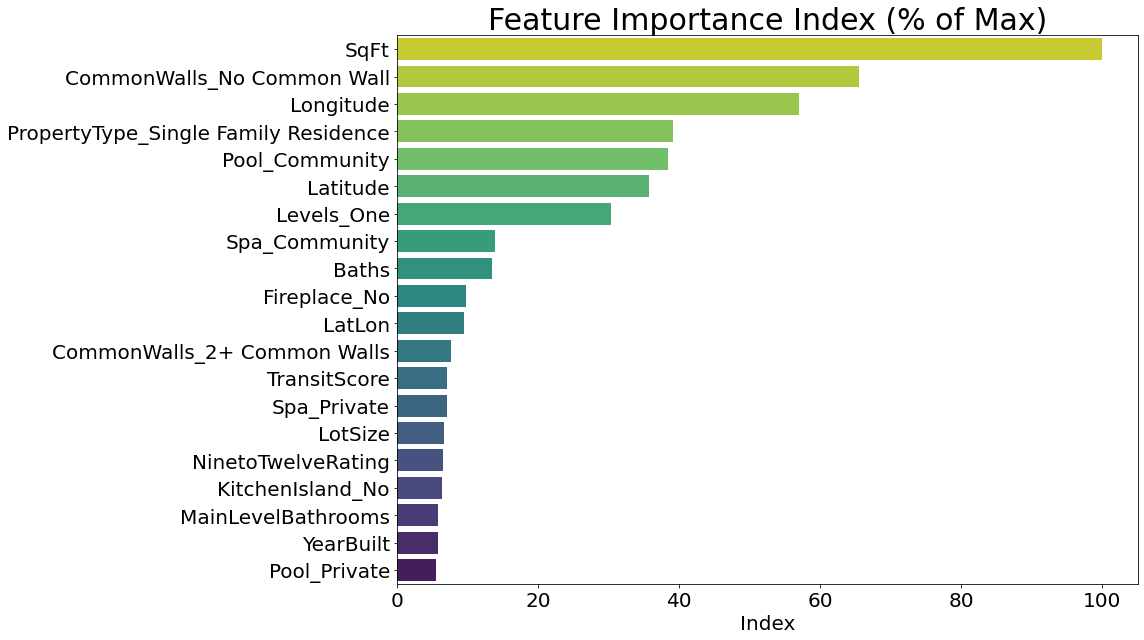

In [42]:
# Feature Importance
features = sorted(zip(X_train.columns, xgbr.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*features) # this splits the list of tuples into two lists
feature_data = pd.DataFrame({'Feature':a, 'Importance':b})
feature_data['Importance'] = feature_data['Importance']/feature_data['Importance'].max() * 100
feature_data = feature_data.loc[feature_data['Importance']>=5]

# Create Figure
f, ax = plt.subplots(figsize=(16, 9))
ax = sns.barplot(y='Feature', x='Importance', palette='viridis_r', data=feature_data)
ax.set_title('Feature Importance Index (% of Max)', size=30)
ax.set_xlabel('Index', size=20)
ax.set_yticklabels(feature_data.Feature,size=20)
ax.set_xticklabels(np.arange(0,120,20),size=20)
ax.set_ylabel('')
f.tight_layout()
f.savefig('../output/figure_6.pdf')

In [59]:
#xgbr = pickle.load(open("../output/redfin.pkl", "rb"))
#xgbr.fit(X_train_prep,y_train)
xgbr.score(X_test_prep,y_test)

0.8243742426071256